In [12]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import gc
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from importlib import reload
import date
reload(date)
from date import *
import model
reload(model)
from model import *
from metric import get_weights, NWRMSLE_log

In [2]:
df = load_data_in_date_range('./data/train_processed.csv', '2017-04-04', '2017-08-15', 110000000)

Reading batch from position 110000000, batch size 10000000...
Filtering 10000000...
Filtered 8659998, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 120000000, batch size 10000000...
Filtering 5497041...
Filtered 5497041, mapping...
Mapped, reducing...
Batch done.
End of dataset is found.


In [3]:
df = convert_unit_sales(df)
df = fill_empty_sales(df)

df_prev = df[['item_nbr', 'store_nbr', 'date', 'unit_sales']]
df, cols_lagged = fill_lagged(df, df_prev, 12, 18, True)
combinations = [['store_nbr','item_nbr', 'onpromotion']]
df, cols_mean = add_mean_encoding(df, combinations)

df.head()

/home/ubuntu/.local/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ubuntu/grocery/model.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_prev[colname] = df_prev['unit_sales']


Processing lagged 12...
Lagged 12 is done.
Processing lagged 13...
Lagged 13 is done.
Processing lagged 14...
Lagged 14 is done.
Processing lagged 15...
Lagged 15 is done.
Processing lagged 16...
Lagged 16 is done.
Processing lagged 17...
Lagged 17 is done.
Processing lagged 18...
Lagged 18 is done.


,date,store_nbr,item_nbr,id,unit_sales,onpromotion,unit_sales(t-12),unit_sales(t-13),unit_sales(t-14),unit_sales(t-15),unit_sales(t-16),unit_sales(t-17),unit_sales(t-18),mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)
0,1576,46,1695836,113723318.0,3.983762,True,0.000000,2.519459,3.736180,2.562543,2.337137,4.329911,0.000000,3.759474
1,1576,46,1695837,113723319.0,2.596886,True,1.568372,1.610999,1.583318,1.061135,2.051215,2.390052,2.177057,1.755228
2,1576,46,1695840,113723320.0,1.098612,True,2.197225,2.708050,1.791759,1.791759,1.945910,1.609438,1.945910,1.730986
3,1576,46,1695845,113723321.0,3.044523,True,3.610918,3.784190,3.713572,3.135494,3.178054,3.970292,3.688879,3.595048
4,1576,46,1695846,113723322.0,1.583318,True,1.059444,1.029898,1.362078,1.232469,0.733813,1.667117,2.067159,1.075955


In [4]:
items = pd.read_csv('./data/items_encoded.csv')
stores = pd.read_csv('./data/stores_encoded.csv')

In [5]:
!telegram-send "Data is ready"

In [21]:
folds = [('2017-05-16', '2017-06-30', '2017-07-01', '2017-07-15'), #('2017-05-01', '2017-06-15', '2017-06-16', '2017-06-30'),
         ('2017-06-01', '2017-07-15', '2017-07-16', '2017-07-31'),
         ('2017-06-16', '2017-07-31', '2017-08-01', '2017-08-15')]

param = {
    'num_leaves':30,
    'objective':'regression_l2',
    'metric':'l2_root',
    'num_threads':4
        }

num_round=150

In [22]:
to_remove = {'perishable', 'type', 'city', 'family'}
def remove_cols(cols, remove):
    return list(set(cols) - set(remove))

In [27]:
results = []
bsts = []

for train_start, train_end, test_start, test_end in folds:
    print("Extracting fold...")
    train = extract_by_date(df, train_start, train_end)
    test = extract_by_date(df, test_start, test_end)
    
    print("Preparing train...")
    train, ext_cols = extend_dataset(train, items, stores)
    ext_cols = remove_cols(ext_cols, to_remove)
    x_cols = ext_cols + ['onpromotion'] + cols_lagged + cols_mean
    cat_cols = ext_cols + ['onpromotion']
    train_X = train[x_cols]
    train_y = train['unit_sales']
    train_weights = get_weights(train['item_nbr'])
    train_dataset = lgb.Dataset(train_X, label=train_y, weight=train_weights)
    #del train
    
    print("Preparing test...")
    test, _ = extend_dataset(test, items, stores)
    test_X = test[x_cols]
    test_y = test['unit_sales']
    test_weights = get_weights(test['item_nbr'])
    test_dataset = lgb.Dataset(test_X, label=test_y, weight=test_weights, reference=train_dataset)
    #del test
    
    bst = lgb.train(param, 
                    train_dataset, 
                    num_round,
                    valid_sets=[test_dataset], 
                    early_stopping_rounds=10, 
                    verbose_eval=True, 
                    feature_name=x_cols, 
                    categorical_feature=cat_cols)
    
    test_y_pred = bst.predict(test_X)
    error = NWRMSLE_log(test_y_pred, test_y, test_weights)
    print('Validation error: {}'.format(error))
    print("="*80)
    
    results.append(error)
    bsts.append(bst)

Extracting fold...
Preparing train...
Preparing test...
Training!


/home/ubuntu/.local/lib/python3.5/site-packages/lightgbm/basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['class', 'cluster', 'salary', 'state', 'weekday', 'weekend']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 0.984755
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 0.920569
[3]	valid_0's rmse: 0.864838
[4]	valid_0's rmse: 0.816831
[5]	valid_0's rmse: 0.775697
[6]	valid_0's rmse: 0.740384
[7]	valid_0's rmse: 0.710484
[8]	valid_0's rmse: 0.685173
[9]	valid_0's rmse: 0.663785
[10]	valid_0's rmse: 0.645792
[11]	valid_0's rmse: 0.630557
[12]	valid_0's rmse: 0.617789
[13]	valid_0's rmse: 0.607187
[14]	valid_0's rmse: 0.598351
[15]	valid_0's rmse: 0.590961
[16]	valid_0's rmse: 0.58478
[17]	valid_0's rmse: 0.579695
[18]	valid_0's rmse: 0.575456
[19]	valid_0's rmse: 0.571883
[20]	valid_0's rmse: 0.568835
[21]	valid_0's rmse: 0.566299
[22]	valid_0's rmse: 0.564112
[23]	valid_0's rmse: 0.562341
[24]	valid_0's rmse: 0.560832
[25]	valid_0's rmse: 0.559525
[26]	valid_0's rmse: 0.558422
[27]	valid_0's rmse: 0.557455
[28]	valid_0's rmse: 0.556643
[29]	valid_0's rmse: 0.555932
[30]	valid_0's rmse: 0.555296
[31]	valid_0's rmse: 0.554727
[32]	valid_0's rms

[116]	valid_0's rmse: 0.540295
[117]	valid_0's rmse: 0.54028
[118]	valid_0's rmse: 0.540255
[119]	valid_0's rmse: 0.540243
[120]	valid_0's rmse: 0.540235
[121]	valid_0's rmse: 0.540243
[122]	valid_0's rmse: 0.540239
[123]	valid_0's rmse: 0.540235
[124]	valid_0's rmse: 0.540233
[125]	valid_0's rmse: 0.540212
[126]	valid_0's rmse: 0.540202
[127]	valid_0's rmse: 0.540199
[128]	valid_0's rmse: 0.5402
[129]	valid_0's rmse: 0.54018
[130]	valid_0's rmse: 0.540186
[131]	valid_0's rmse: 0.540183
[132]	valid_0's rmse: 0.540185
[133]	valid_0's rmse: 0.540166
[134]	valid_0's rmse: 0.540159
[135]	valid_0's rmse: 0.54015
[136]	valid_0's rmse: 0.540143
[137]	valid_0's rmse: 0.540124
[138]	valid_0's rmse: 0.540121
[139]	valid_0's rmse: 0.540119
[140]	valid_0's rmse: 0.540105
[141]	valid_0's rmse: 0.540103
[142]	valid_0's rmse: 0.540097
[143]	valid_0's rmse: 0.540077
[144]	valid_0's rmse: 0.540091
[145]	valid_0's rmse: 0.540084
[146]	valid_0's rmse: 0.540083
[147]	valid_0's rmse: 0.540078
[148]	valid_0

In [28]:
!telegram-send "Lagged xgb validation finished. Results: $results"

In [29]:
x_cols

['state',
 'salary',
 'cluster',
 'weekday',
 'class',
 'weekend',
 'onpromotion',
 'unit_sales(t-12)',
 'unit_sales(t-13)',
 'unit_sales(t-14)',
 'unit_sales(t-15)',
 'unit_sales(t-16)',
 'unit_sales(t-17)',
 'unit_sales(t-18)',
 'mean_unit_sales_by_(store_nbr+item_nbr+onpromotion)']

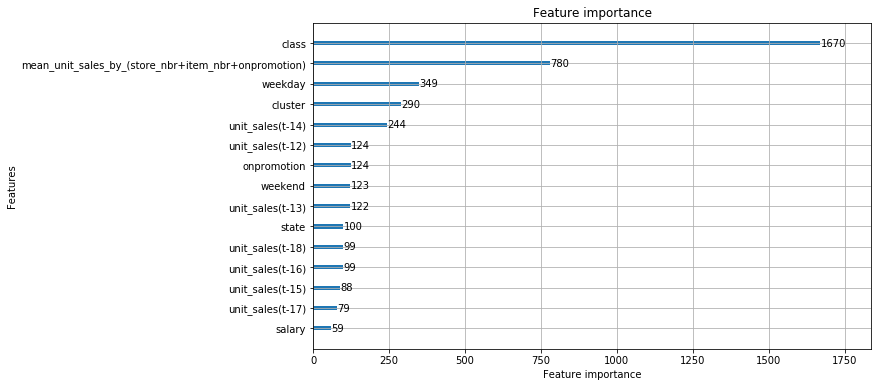

In [31]:
lgb.plot_importance(bsts[0])

In [10]:
param['task'] = 'prediction'
start = '2017-07-01'
end = '2017-08-15'
num_round = 100
train = extract_by_date(df, start, end)
train, ext_cols = extend_dataset(train, items, stores)
x_cols = ext_cols + ['onpromotion'] + lagged_cols
train_X = train[x_cols]
train_y = train['unit_sales']
train_weights = get_weights(train['item_nbr'])
train_dataset = lgb.Dataset(train_X, label=train_y, weight=train_weights)
bst = lgb.train(param, 
                train_dataset,
                num_round,
                feature_name=x_cols, 
                categorical_feature=ext_cols)

C:\Users\Anatoliy\Anaconda2\envs\py35\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['city', 'class', 'cluster', 'family', 'perishable', 'salary', 'state', 'type', 'weekday', 'weekend']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [11]:
test = pd.read_csv('./data/test_processed.csv', dtype=types)

df_prev = extract_by_date(df, '2017-07-25', '2017-08-15')
test = fill_mean_encoding(test, df_prev)
test = fill_lagged(test, df_prev, 12, 18)

test, ext_cols = extend_dataset(test, items, stores)
x_cols = ext_cols + ['onpromotion'] + lagged_cols
test_X = test[x_cols]
test['unit_sales'] = bst.predict(test_X)

C:\Users\Anatoliy\Anaconda2\envs\py35\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\Anatoliy\Documents\PROJECTS\grocery\model.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_prev[colname] = df_prev['unit_sales']


In [14]:
test.sort_values(by='id', inplace=True)
test.ix[test.unit_sales < 0, 'unit_sales'] = 0
test[['id', 'unit_sales']].to_csv('./submissions/lgb_lagged_0.54.csv.gz', float_format="%.4f", index=False, compression='gzip')
!telegram-send "Submission done."

In [2]:
submission = pd.read_csv('./submissions/lgb_lagged_0.54.csv.gz', compression='gzip')
submission.ix[submission.unit_sales < 0, 'unit_sales'] = 0
submission['unit_sales'] = np.expm1(submission['unit_sales'])
submission.to_csv('./submissions/lgb_lagged_0.54.csv.gz', float_format="%.4f", index=False, compression='gzip')
!telegram-send "Submission done."